# Incêndios florestais na Austrália   
  
O objetivo deste projeto é mostrar todos os passos do meu racionínio na tentativa de treinar um modelo capaz de prever áreas de incêndios florestais em regiões da Austrália. Os datasets utilizados são de um [desafio](https://developer.ibm.com/data/spot-challenge-wildfires/) da IBM.  
  
São quatro diferentes datasets com informações a respeito da vegetação e clima em diferentes regiões e também a soma das áreas afetadas por incêndios para cada dia e região entre 2005 e 2021.  
  
Um dataset contendo previsões futuras para as variáveis climáticas é fornecido para a realização das previsões finais do desafio, mas limito este projeto somente ao treinamento do modelo.

## 1 - Setup

In [1]:
import math
from datetime import datetime
import pickle 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.base import BaseEstimator, TransformerMixin

## 2 - Carregar e apresentar os dados

### 2.1 - Tabela "wildfires"

In [2]:
wildfires=pd.read_csv('Historical_Wildfires.csv')
wildfires.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [3]:
wildfires.tail(5)

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
26734,WA,1/24/2021,5.280,331.250000,75.066667,91.000000,6.244998,39.000000,3,N
26735,WA,1/25/2021,3.720,317.100000,28.800000,80.500000,3.535534,12.500000,2,N
26736,WA,1/26/2021,23.460,333.564286,273.871429,90.714286,5.122313,26.238095,7,N
26737,WA,1/27/2021,2.640,342.875000,73.500000,93.500000,9.192388,84.500000,2,N
26738,WA,1/28/2021,13.824,330.595000,61.650000,90.000000,8.110350,65.777778,10,N


In [4]:
wildfires.describe()

,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count
count,26739.000000,26739.000000,26739.000000,26739.000000,24491.000000,24491.000000,26739.000000
mean,143.549854,319.711160,83.742246,87.579312,7.227493,56.233972,71.711919
std,313.102808,8.898425,68.579091,4.376322,1.999370,25.937826,150.390183
min,1.000000,290.700000,0.000000,76.000000,0.000000,0.000000,1.000000
25%,8.815000,313.955599,44.101087,85.000000,6.685316,44.693444,5.000000
50%,38.108571,319.838542,67.100000,87.781250,7.707140,59.400000,20.000000
75%,146.211667,325.470841,103.153691,90.500000,8.239119,67.883076,74.000000
max,10120.943170,381.950000,2178.600000,100.000000,16.970563,288.000000,3954.000000


'Estimated_fire_area' é a nossa variável target. Trata-se da área de vegetação estimada (km²) que estava pegando fogo em uma dada região em um dado dia entre 1/4/2005 e 1/28/2021.  
  
Claramente não está em uma distribuição normal, pois a média, 143.5, é discrepantemente diferente da mediana, 38.1. A média é na verdade muito mais próxima do 3º quartil, o que sugere um desvio para a direita. Vendo essa diferença gigante entre o ponto máximo e o 3º quartil (mais de 30 desvios padrões!),  farejo a presença de outliers. 
  
Vamos confirmar visualmente.

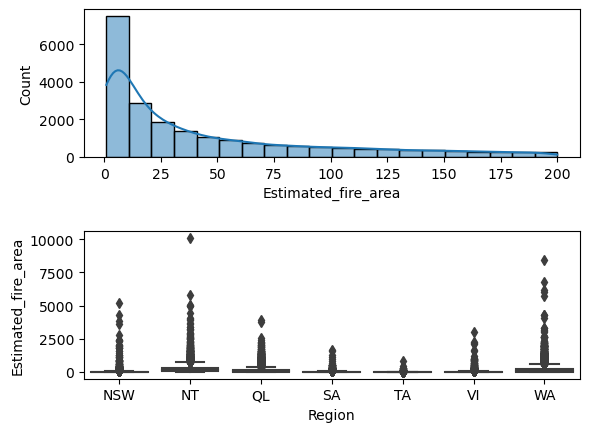

In [5]:
fig, ax = plt.subplots(2)

fire_area_dist=sns.histplot(data=wildfires.loc[wildfires.Estimated_fire_area<200,'Estimated_fire_area'],bins=20, kde=True,ax=ax[0]);

sns.boxplot(y=wildfires.Estimated_fire_area,x=wildfires.Region,ax=ax[1]);

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)

In [6]:
wildfires.Region.value_counts()

WA     5713
QL     5620
NT     5103
NSW    4672
VI     2192
SA     2018
TA     1421
Name: Region, dtype: int64

Cada linha corresponde a uma medição feita num certo dia em uma das seguintes regiões da Austrália:

- NSW: New South Wales
- NT: Northern Territory
- QL: Queensland
- SA: Australia
- TA: Tasmania
- Vl: Victoria
- WA: Western Australia  
  
É importante enfatizar que as datas aparecem na tabela uma vez para cada região.

### 2.2 - Tabela "weather"

In [7]:
weather = pd.read_csv('HistoricalWeather.csv')
weather.head()

,Date,Region,Parameter,count()[unit: km^2],min(),max(),mean(),variance()
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


In [8]:
weather.tail()

,Date,Region,Parameter,count()[unit: km^2],min(),max(),mean(),variance()
246136,2021-01-23,WA,RelativeHumidity,2.528546e+06,2.461761e+01,91.604195,62.136811,332.811746
246137,2021-01-23,WA,SoilWaterContent,2.528546e+06,7.375299e-07,0.479402,0.139733,0.011813
246138,2021-01-23,WA,SolarRadiation,2.528546e+06,2.582241e+00,31.672697,22.091301,59.357413
246139,2021-01-23,WA,Temperature,2.528546e+06,1.914567e+01,34.780716,26.972257,9.312527
246140,2021-01-23,WA,WindSpeed,2.528546e+06,2.157812e+00,9.989105,5.148252,1.198810


In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246141 entries, 0 to 246140
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 246141 non-null  object 
 1   Region               246141 non-null  object 
 2   Parameter            246141 non-null  object 
 3   count()[unit: km^2]  246141 non-null  float64
 4   min()                246141 non-null  float64
 5   max()                246141 non-null  float64
 6   mean()               246141 non-null  float64
 7   variance()           246141 non-null  float64
dtypes: float64(5), object(3)
memory usage: 15.0+ MB


In [10]:
weather.Parameter.value_counts()

SoilWaterContent    41041
Precipitation       41034
SolarRadiation      41027
Temperature         41027
WindSpeed           41013
RelativeHumidity    40999
Name: Parameter, dtype: int64

Esta tabela contém características climáticas de cada região em cada dia entre 2005/01/01 e 2021/01/23. Essas características serão algumas das features do dataframe final após um pouco de data wrangling.

Duas coisas são importantes notar:

- 1 ) Não queremos uma linha por parâmetro, mas sim uma linha por data e região contendo cada parâmetro e seu valor médio como colunas distintas. Para isso, teremos que pivotar a tabela. 
- 2 ) As datas estão em um formato diferente da tabela "wildfires", será preciso padronizar isso se quisermos realizar um join entre as tabelas. 

### 2.3 - Tabela "vegetation"

In [11]:
vegetation = pd.read_csv('VegetationIndex.csv')
vegetation.head()

,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,1/1/2005,0.349202,0.9972,-0.2,0.204862,0.041968
1,NSW,2/1/2005,0.357403,0.9772,-0.2,0.208673,0.043544
2,NSW,3/1/2005,0.354087,0.9750,-0.2,0.209450,0.043869
3,NSW,4/1/2005,0.347242,0.9904,-0.2,0.207307,0.042976
4,NSW,5/1/2005,0.345526,0.9972,-0.2,0.202858,0.041151


In [12]:
vegetation.tail()

,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
1346,WA,9/1/2020,0.234510,0.9849,-0.2,0.126898,0.016103
1347,WA,10/1/2020,0.213640,0.9782,-0.2,0.099860,0.009972
1348,WA,11/1/2020,0.205688,0.9919,-0.2,0.092952,0.008640
1349,WA,12/1/2020,0.217889,0.9864,-0.2,0.098640,0.009730
1350,WA,1/1/2021,0.231074,0.9828,-0.2,0.104376,0.010894


In [13]:
vegetation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Region                     1351 non-null   object 
 1   Date                       1351 non-null   object 
 2   Vegetation_index_mean      1351 non-null   float64
 3   Vegetation_index_max       1351 non-null   float64
 4   Vegetation_index_min       1351 non-null   float64
 5   Vegetation_index_std       1351 non-null   float64
 6   Vegetation_index_variance  1351 non-null   float64
dtypes: float64(5), object(2)
memory usage: 74.0+ KB


Esta tabela nos fornece o índice de vegetação para cada região, normalizado, medido mensalmente. Ele significa basicamente o quão verde é uma região.  
  
Em geral, ter um índice de vegetação baixo representa um estado mais seco, o que pode favorecer a ocorrência de incêndios.

Os incêndios florestais talvez afetem significativamente este índice ao longo do mês. Numa primeira modelagem, vou assumir que este se mantém constante, mas encontrar uma forma de inferir com precisão seu valor em diferentes dias, talvez utilizando um segundo modelo de machine learning, pode melhorar significativamente nossa previsão da variável target (área de incêndio). 

### 2.4 Tabela "landclass"

In [14]:
landclass = pd.read_csv('LandClass.csv')
landclass

,Region,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
0,NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1
1,NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5
2,QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3
3,SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
4,TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0
5,WA,31.3,43.5,5.6,0.0,1.0,0.4,0.0,1.2,2.4,0.2,0.1,4.8,8.7,0.8
6,VI,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9


In [15]:
landclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 15 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Region                                                    7 non-null      object 
 1   Shrubs                                                    7 non-null      float64
 2   Herbaceous vegetation                                     7 non-null      float64
 3   Cultivated and managed vegetation/agriculture (cropland)  7 non-null      float64
 4   Urban / built up                                          7 non-null      float64
 5   Bare / sparse vegetation                                  7 non-null      float64
 6   Permanent water bodies                                    7 non-null      float64
 7   Herbaceous wetland                                        7 non-null      float64
 8   Closed forest, evergreen

Por fim, "landclass" contém características a respeito da ocupação de cada região, como por exemplo porcentagem de arbustos, de florestas fechadas, de área urbanizada, de área cultivada etc. 

Essas medições foram feitas uma única vez, em 2005, portanto me pergunto quanto valor preditivo irão agregar ao modelo. Uma análise exploratória dos dados poderá me trazer insights a respeito disso. Se eu continuar em dúvida, posso desenvolver um pipeline de transformações que possibilite testar a performance do modelo com ou sem essas features. 

## 3 - Data wrangling

Chegou a hora de por a mão na massa e de mexer nas tabelas: transformá-las e deixá-las em um formato adequado para realizar a junção que resultará na tabela final que de fato será utilizada para treinar o modelo.

### 3.1 - Datas

Em primeiro lugar, vou padronizar as datas em todas as tabelas para um mesmo formato. A estratégia que utilizo aqui constinui em separar cada componente das datas em diferentes colunas para depois gerar uma única coluna no formato datetime. 

In [16]:
wildfires.Date=pd.to_datetime(wildfires.Date.str.split('/',expand=True).rename({0:'month',1:'day',2:'year'},axis=1))

In [17]:
weather.Date=pd.to_datetime(weather.Date.str.split('-',expand=True).rename({0:'year',1:'month',2:'day'},axis=1))

In [18]:
vegetation.Date=pd.to_datetime(vegetation.Date.str.split('/',expand=True).rename({0:'month',1:'day',2:'year'},axis=1))

### 3.2 - Formatação das tabelas

In [19]:
wildfires_tr=wildfires.loc[:,['Region','Date','Estimated_fire_area']].set_index(['Region','Date']).rename({'Estimated_fire_area':'FireArea'},axis=1)
wildfires_tr

FireArea
Region Date                
NSW    2005-01-04   8.68000
       2005-01-05  16.61125
       2005-01-06   5.52000
       2005-01-07   6.26400
       2005-01-08   5.40000
...                     ...
WA     2021-01-24   5.28000
       2021-01-25   3.72000
       2021-01-26  23.46000
       2021-01-27   2.64000
       2021-01-28  13.82400

[26739 rows x 1 columns]

In [20]:
weather_tr=weather.pivot(index=['Region','Date'], columns='Parameter', values='mean()')
weather_tr

Parameter          Precipitation  RelativeHumidity  SoilWaterContent  \
Region Date                                                            
NSW    2005-01-01       0.044274         36.355567          0.170931   
       2005-01-02       0.173879         38.699607          0.169551   
       2005-01-03       3.011912         49.365152          0.179981   
       2005-01-04       2.808620         57.095628          0.214293   
       2005-01-05       0.157935         47.170735          0.203951   
...                          ...               ...               ...   
WA     2021-01-18       0.151120         31.117912          0.054056   
       2021-01-20       1.175004         37.098867          0.059494   
       2021-01-21       6.245726         45.299281          0.082419   
       2021-01-22       9.560854         54.601879          0.117431   
       2021-01-23       5.692838         62.136811          0.139733   

Parameter          SolarRadiation  Temperature  WindSpeed  
Region Date                                                
NSW    2005-01-01       26.749389    27.341182   3.323550  
       2005-01-02       27.047523    26.143898   3.030897  
       2005-01-03       24.197452    27.408810   3.958409  
       2005-01-04       22.617291    23.055527   4.841764  
       2005-01-05       28.076835    22.425765   4.014080  
...                           ...          ...        ...  
WA     2021-01-18       26.931745    29.404902   4.816861  
       2021-01-20       26.274548    31.288251   4.074024  
       2021-01-21       23.716351    30.420936   4.180499  
       2021-01-22       21.390922    28.678576   4.976033  
       2021-01-23       22.091301    26.972257   5.148252  

[41041 rows x 6 columns]

In [21]:
vegetation_tr=vegetation.loc[:,['Region','Date','Vegetation_index_mean']].set_index(['Region','Date']).rename({'Vegetation_index_mean':'VegetationIndex'},axis=1)
vegetation_tr

VegetationIndex
Region Date                       
NSW    2005-01-01         0.349202
       2005-02-01         0.357403
       2005-03-01         0.354087
       2005-04-01         0.347242
       2005-05-01         0.345526
...                            ...
WA     2020-09-01         0.234510
       2020-10-01         0.213640
       2020-11-01         0.205688
       2020-12-01         0.217889
       2021-01-01         0.231074

[1351 rows x 1 columns]

In [22]:
landclass.columns

Index(['Region', 'Shrubs', 'Herbaceous vegetation',
       'Cultivated and managed vegetation/agriculture (cropland)',
       'Urban / built up', 'Bare / sparse vegetation',
       'Permanent water bodies', 'Herbaceous wetland',
       'Closed forest, evergreen, broad leaf',
       'Closed forest, deciduous broad leaf', 'Closed forest, unknown',
       'Open forest, evergreen broad leaf',
       'Open forest, deciduous broad leaf', 'Open forest, unknown definitions',
       'Open sea'],
      dtype='object')

In [23]:
new_names={'Herbaceous vegetation':'Herbaceous',
       'Cultivated and managed vegetation/agriculture (cropland)':'Cropland',
       'Urban / built up':'Urban', 'Bare / sparse vegetation':'SparseVegetation',
       'Permanent water bodies':'PermanentWaterBodies', 'Herbaceous wetland':'HerbaceousWetland',
       'Closed forest, evergreen, broad leaf':'ClosedForestEvergreen',
       'Closed forest, deciduous broad leaf':'ClosedForestDeciduous', 'Closed forest, unknown':'ClosedForestUnknown',
       'Open forest, evergreen broad leaf':'OpenForestEvergreen',
       'Open forest, deciduous broad leaf':'OpenForestDeciduous', 'Open forest, unknown definitions':'OpenForestUnknown',
       'Open sea':'OpenSea'}

landclass_tr=landclass.rename(new_names,axis=1).set_index('Region')
landclass_tr

,Shrubs,Herbaceous,Cropland,Urban,SparseVegetation,PermanentWaterBodies,HerbaceousWetland,ClosedForestEvergreen,ClosedForestDeciduous,ClosedForestUnknown,OpenForestEvergreen,OpenForestDeciduous,OpenForestUnknown,OpenSea
Region,,,,,,,,,,,,,,
NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1
NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5
QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3
SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0
WA,31.3,43.5,5.6,0.0,1.0,0.4,0.0,1.2,2.4,0.2,0.1,4.8,8.7,0.8
VI,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9


### 3.3 - Junção das tabelas em um único dataframe: "data"

In [24]:
data=wildfires_tr.merge(weather_tr,left_index=True,right_index=True,how='inner')
data

FireArea  Precipitation  RelativeHumidity  \
Region Date                                                      
NSW    2005-01-04    8.680000       2.808620         57.095628   
       2005-01-05   16.611250       0.157935         47.170735   
       2005-01-06    5.520000       0.434833         39.874638   
       2005-01-07    6.264000       0.064224         39.279410   
       2005-01-08    5.400000       0.203352         42.400824   
...                       ...            ...               ...   
WA     2021-01-18   30.800000       0.151120         31.117912   
       2021-01-20    6.720000       1.175004         37.098867   
       2021-01-21  198.362182       6.245726         45.299281   
       2021-01-22   59.355333       9.560854         54.601879   
       2021-01-23  178.624865       5.692838         62.136811   

                   SoilWaterContent  SolarRadiation  Temperature  WindSpeed  
Region Date                                                                  
NSW    2005-01-04          0.214293       22.617291    23.055527   4.841764  
       2005-01-05          0.203951       28.076835    22.425765   4.014080  
       2005-01-06          0.193668       30.561703    20.621405   4.477879  
       2005-01-07          0.183778       32.143718    19.632722   4.017578  
       2005-01-08          0.175935       29.347715    21.477315   3.884550  
...                             ...             ...          ...        ...  
WA     2021-01-18          0.054056       26.931745    29.404902   4.816861  
       2021-01-20          0.059494       26.274548    31.288251   4.074024  
       2021-01-21          0.082419       23.716351    30.420936   4.180499  
       2021-01-22          0.117431       21.390922    28.678576   4.976033  
       2021-01-23          0.139733       22.091301    26.972257   5.148252  

[26704 rows x 7 columns]

In [25]:
data=data.merge(vegetation_tr,left_index=True,right_index=True,how='outer')
data

FireArea  Precipitation  RelativeHumidity  \
Region Date                                                      
NSW    2005-01-01         NaN            NaN               NaN   
       2005-01-04    8.680000       2.808620         57.095628   
       2005-01-05   16.611250       0.157935         47.170735   
       2005-01-06    5.520000       0.434833         39.874638   
       2005-01-07    6.264000       0.064224         39.279410   
...                       ...            ...               ...   
WA     2021-01-18   30.800000       0.151120         31.117912   
       2021-01-20    6.720000       1.175004         37.098867   
       2021-01-21  198.362182       6.245726         45.299281   
       2021-01-22   59.355333       9.560854         54.601879   
       2021-01-23  178.624865       5.692838         62.136811   

                   SoilWaterContent  SolarRadiation  Temperature  WindSpeed  \
Region Date                                                                   
NSW    2005-01-01               NaN             NaN          NaN        NaN   
       2005-01-04          0.214293       22.617291    23.055527   4.841764   
       2005-01-05          0.203951       28.076835    22.425765   4.014080   
       2005-01-06          0.193668       30.561703    20.621405   4.477879   
       2005-01-07          0.183778       32.143718    19.632722   4.017578   
...                             ...             ...          ...        ...   
WA     2021-01-18          0.054056       26.931745    29.404902   4.816861   
       2021-01-20          0.059494       26.274548    31.288251   4.074024   
       2021-01-21          0.082419       23.716351    30.420936   4.180499   
       2021-01-22          0.117431       21.390922    28.678576   4.976033   
       2021-01-23          0.139733       22.091301    26.972257   5.148252   

                   VegetationIndex  
Region Date                         
NSW    2005-01-01         0.349202  
       2005-01-04              NaN  
       2005-01-05              NaN  
       2005-01-06              NaN  
       2005-01-07              NaN  
...                            ...  
WA     2021-01-18              NaN  
       2021-01-20              NaN  
       2021-01-21              NaN  
       2021-01-22              NaN  
       2021-01-23              NaN  

[27187 rows x 8 columns]

In [26]:
data=data.merge(landclass_tr,left_index=True,right_index=True)
data.head()

FireArea  Precipitation  RelativeHumidity  \
Region Date                                                    
NSW    2005-01-01       NaN            NaN               NaN   
       2005-01-04   8.68000       2.808620         57.095628   
       2005-01-05  16.61125       0.157935         47.170735   
       2005-01-06   5.52000       0.434833         39.874638   
       2005-01-07   6.26400       0.064224         39.279410   

                   SoilWaterContent  SolarRadiation  Temperature  WindSpeed  \
Region Date                                                                   
NSW    2005-01-01               NaN             NaN          NaN        NaN   
       2005-01-04          0.214293       22.617291    23.055527   4.841764   
       2005-01-05          0.203951       28.076835    22.425765   4.014080   
       2005-01-06          0.193668       30.561703    20.621405   4.477879   
       2005-01-07          0.183778       32.143718    19.632722   4.017578   

                   VegetationIndex  Shrubs  Herbaceous  ...  SparseVegetation  \
Region Date                                             ...                     
NSW    2005-01-01         0.349202     6.2        43.6  ...               0.2   
       2005-01-04              NaN     6.2        43.6  ...               0.2   
       2005-01-05              NaN     6.2        43.6  ...               0.2   
       2005-01-06              NaN     6.2        43.6  ...               0.2   
       2005-01-07              NaN     6.2        43.6  ...               0.2   

                   PermanentWaterBodies  HerbaceousWetland  \
Region Date                                                  
NSW    2005-01-01                   0.2                0.1   
       2005-01-04                   0.2                0.1   
       2005-01-05                   0.2                0.1   
       2005-01-06                   0.2                0.1   
       2005-01-07                   0.2                0.1   

                   ClosedForestEvergreen  ClosedForestDeciduous  \
Region Date                                                       
NSW    2005-01-01                   14.7                    6.8   
       2005-01-04                   14.7                    6.8   
       2005-01-05                   14.7                    6.8   
       2005-01-06                   14.7                    6.8   
       2005-01-07                   14.7                    6.8   

                   ClosedForestUnknown  OpenForestEvergreen  \
Region Date                                                   
NSW    2005-01-01                  0.3                  0.5   
       2005-01-04                  0.3                  0.5   
       2005-01-05                  0.3                  0.5   
       2005-01-06                  0.3                  0.5   
       2005-01-07                  0.3                  0.5   

                   OpenForestDeciduous  OpenForestUnknown  OpenSea  
Region Date                                                         
NSW    2005-01-01                  3.7               10.3      0.1  
       2005-01-04                  3.7               10.3      0.1  
       2005-01-05                  3.7               10.3      0.1  
       2005-01-06                  3.7               10.3      0.1  
       2005-01-07                  3.7               10.3      0.1  

[5 rows x 22 columns]

### 3.4 - NaNs na coluna VegetationIndex

Só vou lidar com os NaNs após uma análise exploratória me trazer insights a respeito do que fazer com eles. No entanto, a coluna VegetationIndex é um caso particular, como só há medições feitas no início de cada mês, ela está completamente esburacada e vou precisar dela para a análise exploratória.  
  
Considerarei que o índice de vegetação não se altera de forma significativa em um mesmo mês, o que pode ser extremamente errôneo, como disse anteriormente, mas é um risco que estou disposto a assumir, por ora, para simplificar as coisas. Posteriormente posso voltar neste ponto e buscar uma maneira de inferir os valores que faltam. 

In [27]:
data.VegetationIndex.fillna(method='ffill',inplace=True)

In [28]:
data.head()

FireArea  Precipitation  RelativeHumidity  \
Region Date                                                    
NSW    2005-01-01       NaN            NaN               NaN   
       2005-01-04   8.68000       2.808620         57.095628   
       2005-01-05  16.61125       0.157935         47.170735   
       2005-01-06   5.52000       0.434833         39.874638   
       2005-01-07   6.26400       0.064224         39.279410   

                   SoilWaterContent  SolarRadiation  Temperature  WindSpeed  \
Region Date                                                                   
NSW    2005-01-01               NaN             NaN          NaN        NaN   
       2005-01-04          0.214293       22.617291    23.055527   4.841764   
       2005-01-05          0.203951       28.076835    22.425765   4.014080   
       2005-01-06          0.193668       30.561703    20.621405   4.477879   
       2005-01-07          0.183778       32.143718    19.632722   4.017578   

                   VegetationIndex  Shrubs  Herbaceous  ...  SparseVegetation  \
Region Date                                             ...                     
NSW    2005-01-01         0.349202     6.2        43.6  ...               0.2   
       2005-01-04         0.349202     6.2        43.6  ...               0.2   
       2005-01-05         0.349202     6.2        43.6  ...               0.2   
       2005-01-06         0.349202     6.2        43.6  ...               0.2   
       2005-01-07         0.349202     6.2        43.6  ...               0.2   

                   PermanentWaterBodies  HerbaceousWetland  \
Region Date                                                  
NSW    2005-01-01                   0.2                0.1   
       2005-01-04                   0.2                0.1   
       2005-01-05                   0.2                0.1   
       2005-01-06                   0.2                0.1   
       2005-01-07                   0.2                0.1   

                   ClosedForestEvergreen  ClosedForestDeciduous  \
Region Date                                                       
NSW    2005-01-01                   14.7                    6.8   
       2005-01-04                   14.7                    6.8   
       2005-01-05                   14.7                    6.8   
       2005-01-06                   14.7                    6.8   
       2005-01-07                   14.7                    6.8   

                   ClosedForestUnknown  OpenForestEvergreen  \
Region Date                                                   
NSW    2005-01-01                  0.3                  0.5   
       2005-01-04                  0.3                  0.5   
       2005-01-05                  0.3                  0.5   
       2005-01-06                  0.3                  0.5   
       2005-01-07                  0.3                  0.5   

                   OpenForestDeciduous  OpenForestUnknown  OpenSea  
Region Date                                                         
NSW    2005-01-01                  3.7               10.3      0.1  
       2005-01-04                  3.7               10.3      0.1  
       2005-01-05                  3.7               10.3      0.1  
       2005-01-06                  3.7               10.3      0.1  
       2005-01-07                  3.7               10.3      0.1  

[5 rows x 22 columns]

In [29]:
data.reset_index(inplace=True)

## 4 - Train set e test set

Para que possamos testar o modelo antes de seguirmos para a fase de implantação, é preciso dividir os dados em train set e test set. O test set será deixado de lado por enquanto e todas as análises e decisões a respeito de limpeza, transformação, engenharia de feature (se houver) e escolha dos modelos com seus respectivos hiperparâmetros, tal como o treinamento destes modelos, serão feitas com o conjunto de treino (train set). Tudo isso para não enviesar o modelo e não torná-lo "especialista" em prever o test set, afinal, estamos interessados em treinar um modelo que generalize bem.  

In [30]:
data.Region.value_counts(normalize=True)

WA     0.210027
QL     0.206606
NT     0.188399
NSW    0.173281
VI     0.084857
SA     0.078935
TA     0.057895
Name: Region, dtype: float64

In [31]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [32]:
train_set.Region.value_counts(normalize=True)

WA     0.209757
QL     0.205665
NT     0.187733
NSW    0.173525
VI     0.084004
SA     0.080693
TA     0.058623
Name: Region, dtype: float64

In [33]:
test_set.Region.value_counts(normalize=True)

WA     0.211107
QL     0.210371
NT     0.191063
NSW    0.172306
VI     0.088268
SA     0.071901
TA     0.054983
Name: Region, dtype: float64

As tabelas acima mostram que a proporção de cada região se manteve após o splitting.  
  
Vale a pena confirmar se a distribuição da variável target também se manteve, afinal, queremos treinar nosso modelo para todo o range de possibilidades. Uma boa maneira de verificar isso visualmente é através de um gráfico de densidade.

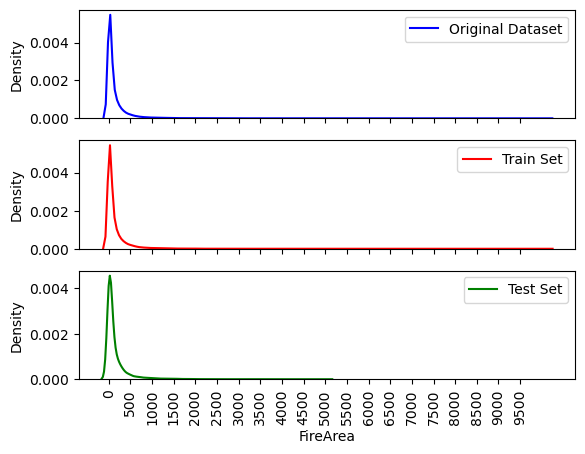

In [34]:
fig, ax = plt.subplots(3,sharex=True)

sns.kdeplot(data.FireArea,color='blue',label='Original Dataset',ax=ax[0]);
sns.kdeplot(train_set.FireArea,color='red',label='Train Set',ax=ax[1]);
sns.kdeplot(test_set.FireArea,color='green',label='Test Set',ax=ax[2]);

ax[0].legend();
ax[1].legend();
ax[2].legend();
x_ticks=np.arange(0,10000,500)
x_ticks_labels=[str(x) for x in x_ticks]
ax[2].set_xticks(x_ticks,labels=x_ticks_labels, rotation=90);

Excelente. A distribuição da variável target parece ter se mantido nos conjuntos de treino e de teste. O único problema é que não há valores acima de 5500 no conjunto teste, dessa maneira não há como testar o poder preditivo do modelo final para valores muito grandes. Uma possível solução seria fazer um splitting estratificado, mas é provável que esses valores altos sejam outliers e, portanto, raros. 

In [35]:
train_set.to_csv('train_set.csv')
test_set.to_csv('test_set.csv')

## 5 - Análise Exploratória dos Dados (EDA)

In [36]:
landclass_features=list(landclass_tr.columns)
weather_features=list(weather_tr.columns)
vegetation_features=['VegetationIndex']

<Axes: xlabel='Date', ylabel='FireArea'>

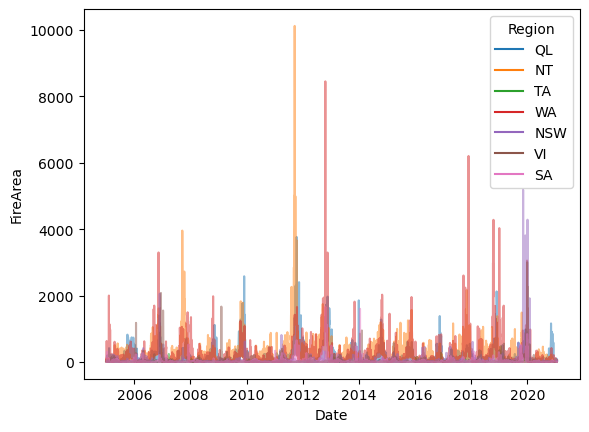

In [37]:
fig, ax = plt.subplots()
sns.lineplot(data=train_set,x='Date',y='FireArea',hue='Region',ax=ax,alpha=0.5)

### 5.1 - Quais tipos de features temos?

In [38]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21749 entries, 14338 to 23654
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Region                 21749 non-null  object        
 1   Date                   21749 non-null  datetime64[ns]
 2   FireArea               21360 non-null  float64       
 3   Precipitation          21357 non-null  float64       
 4   RelativeHumidity       21335 non-null  float64       
 5   SoilWaterContent       21360 non-null  float64       
 6   SolarRadiation         21354 non-null  float64       
 7   Temperature            21352 non-null  float64       
 8   WindSpeed              21346 non-null  float64       
 9   VegetationIndex        21749 non-null  float64       
 10  Shrubs                 21749 non-null  float64       
 11  Herbaceous             21749 non-null  float64       
 12  Cropland               21749 non-null  float64       
 1

Exceto pelas colunas Region e Date, que serão removidas antes de treinarmos os modelos, todas as variáveis estão no formato float64, tal como deveriam ser, por isso não será necessária nenhuma conversão. Não precisamos nos preocupar também com cardinalidade, pois não há variáveis preditivas categóricas.

### 5.2 - Missing values (NaNs)

In [39]:
train_set.isna().sum()

Region                     0
Date                       0
FireArea                 389
Precipitation            392
RelativeHumidity         414
SoilWaterContent         389
SolarRadiation           395
Temperature              397
WindSpeed                403
VegetationIndex            0
Shrubs                     0
Herbaceous                 0
Cropland                   0
Urban                      0
SparseVegetation           0
PermanentWaterBodies       0
HerbaceousWetland          0
ClosedForestEvergreen      0
ClosedForestDeciduous      0
ClosedForestUnknown        0
OpenForestEvergreen        0
OpenForestDeciduous        0
OpenForestUnknown          0
OpenSea                    0
dtype: int64

Encontramos NaNs somente na variável target e nas variáveis que vieram da tabela "weather". Felizmente são poucos. Provavelmente vou substituí-los pela mediana, a menos que eu eNcontre nesta EDA um critério melhor.

### 5.2 - Outliers

Vamos contar quantos outliers tem em cada coluna. Considero outliers todos os valores menores que o limite inferior (1ºQ - 1.5 x IQR) ou maiores que o limite superior (3ºQ + 1.5 x IQR).

In [40]:
for column in train_set.columns[2:]:
    ser=train_set[column]
    IQR=ser.quantile(0.75)-ser.quantile(0.25)
    inf_lim=ser.quantile(0.25)-1.5*IQR
    sup_lim=ser.quantile(0.75)+1.5*IQR
    count=0
    for x in ser:
        if x<inf_lim or x>sup_lim:
            count+=1
    print(column,':',count,'outliers','(Inf={0:.2f}, Sup={1:.2f})'.format(inf_lim,sup_lim))

FireArea : 2301 outliers (Inf=-196.23, Sup=350.38)
Precipitation : 2714 outliers (Inf=-1.34, Sup=2.31)
RelativeHumidity : 3 outliers (Inf=7.83, Sup=92.16)
SoilWaterContent : 2 outliers (Inf=-0.12, Sup=0.38)
SolarRadiation : 0 outliers (Inf=1.59, Sup=39.63)
Temperature : 0 outliers (Inf=0.20, Sup=43.16)
WindSpeed : 320 outliers (Inf=1.29, Sup=6.12)
VegetationIndex : 1562 outliers (Inf=0.05, Sup=0.60)
Shrubs : 0 outliers (Inf=-20.65, Sup=50.95)
Herbaceous : 3102 outliers (Inf=35.40, Sup=57.00)
Cropland : 0 outliers (Inf=-15.50, Sup=30.10)
Urban : 1827 outliers (Inf=-0.45, Sup=0.75)
SparseVegetation : 1755 outliers (Inf=-1.15, Sup=2.45)
PermanentWaterBodies : 3030 outliers (Inf=-0.35, Sup=0.85)
HerbaceousWetland : 3102 outliers (Inf=-0.15, Sup=0.25)
ClosedForestEvergreen : 1275 outliers (Inf=-19.55, Sup=35.25)
ClosedForestDeciduous : 0 outliers (Inf=-5.55, Sup=15.65)
ClosedForestUnknown : 1275 outliers (Inf=-0.20, Sup=0.60)
OpenForestEvergreen : 3102 outliers (Inf=-0.50, Sup=1.10)
OpenFor

Definitivamente são muitos outliers. A questão agora é decidir o que fazer com eles. O ideal é realizar uma pesquisa aprofundada a respeito de cada variável para decidir quais outliers são meramente eventos raros porém possíveis e quais são provavelmente um erro na coleta dos dados. E se eu concluir que um certo conjunto de dados foi erroneamente coletado, devo decidir se o excluo ou se substituo os valores por outro número (talvez 0, talvez o limite mais próximo).

Não farei uma ponderação profunda sobre cada variável, pois está fora do escopo deste projeto, mas escolherei algumas para dar uma maior atenção. 

Vamos começar com uma visão panorâmica. Nada como alguns boxplots para isso! 

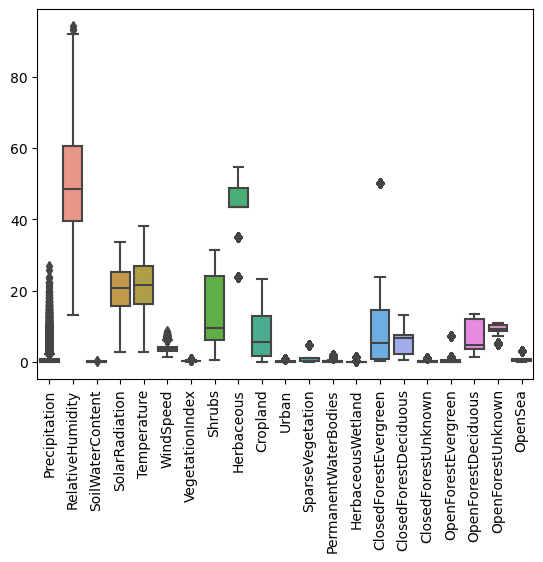

In [41]:
fig, ax = plt.subplots()
sns.boxplot(data=train_set.iloc[:,3:],ax=ax);

ax.set_xticklabels(train_set.iloc[:,3:].columns,rotation=90);

As escalas estão muito diferentes, o que pede por um redimensionamento das features, para que tenham a mesma média e desvio padrão, antes de treinarmos o modelo. Já estou vendo também várias distribuições assimétricas, como a da variável Shrubs.

Mas continuemos a analisar os outliers. Para melhor visualização, vamos plotar as distribuições separadamente, definindo grupos com ranges semelhantes. 

In [42]:
# posição das colunas cujos ranges estão mais próximos de zero 
low=np.array([2,5,6,10,11,12,13,16,17,20])+3

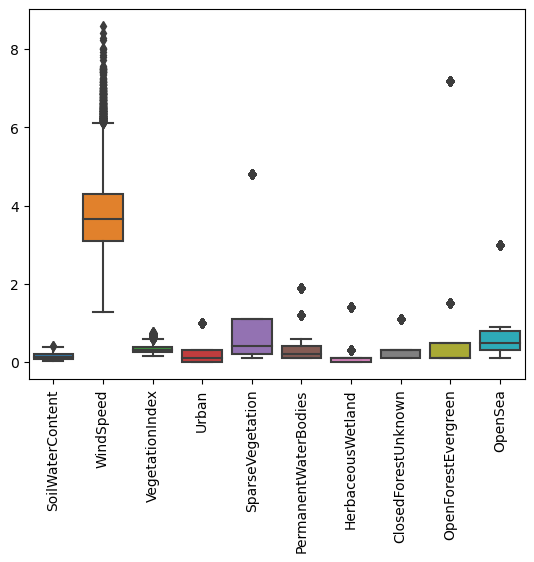

In [43]:
fig, ax = plt.subplots()

sns.boxplot(data=train_set.iloc[:,low],ax=ax);

ax.set_xticklabels(train_set.iloc[:,low].columns,rotation=90);

É interessante como todas as colunas do tipo landclass (Urban até OpenSea) possuem outliers concentrados em um ou dois pontos. Vamos dar um zoom em um desses boxplots. 

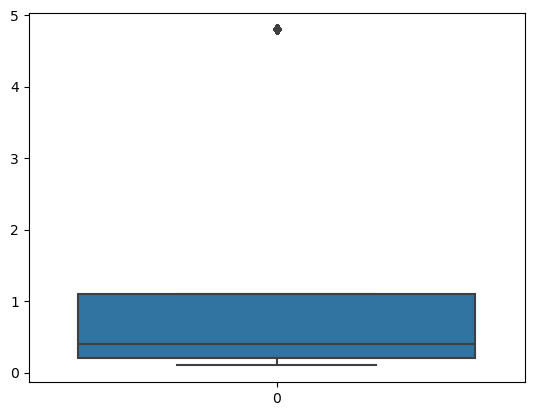

In [44]:
fig, ax = plt.subplots()

sns.boxplot(data=train_set.loc[:,'SparseVegetation'],ax=ax);

Agora vou olhar somente para os outliers.

In [45]:
def getOutliersAt(column, df):
    ser=df[column]
    IQR=ser.quantile(0.75)-ser.quantile(0.25)
    inf_lim=ser.quantile(0.25)-1.5*IQR
    sup_lim=ser.quantile(0.75)+1.5*IQR
    return df.loc[df[column].apply(lambda x: (x<inf_lim or x>sup_lim)),:]

In [46]:
getOutliersAt('SparseVegetation',train_set)

,Region,Date,FireArea,Precipitation,RelativeHumidity,SoilWaterContent,SolarRadiation,Temperature,WindSpeed,VegetationIndex,...,SparseVegetation,PermanentWaterBodies,HerbaceousWetland,ClosedForestEvergreen,ClosedForestDeciduous,ClosedForestUnknown,OpenForestEvergreen,OpenForestDeciduous,OpenForestUnknown,OpenSea
16775,SA,2014-08-30,2.000000,0.001185,31.237382,0.062272,19.000953,17.945536,3.745775,0.257172,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
15546,SA,2005-06-06,18.126000,0.008315,36.475801,0.049673,12.255428,17.563087,3.439790,0.210167,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
15662,SA,2006-05-26,2.640000,0.792863,62.699312,0.076760,10.362679,12.295870,3.551974,0.227940,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
15655,SA,2006-05-15,22.356000,0.000481,53.793776,0.073324,15.147347,13.025804,2.714059,0.227940,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
16738,SA,2014-04-17,35.738387,0.033420,50.268617,0.095588,19.121606,20.453106,2.431557,0.236646,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15787,SA,2007-10-10,8.360000,0.258608,46.238666,0.057943,22.831257,21.873867,5.212998,0.187532,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
17568,SA,2020-11-02,7.280000,0.034557,27.615637,0.071934,28.311193,27.839033,4.576717,0.195611,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
16023,SA,2010-05-02,3.360000,0.005324,52.204868,0.079003,15.684809,18.632101,3.217519,0.242417,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
16850,SA,2015-03-28,1.100000,0.319784,37.871425,0.065926,17.308761,21.030459,2.751097,0.191463,...,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6


In [47]:
getOutliersAt('SparseVegetation',train_set).SparseVegetation.value_counts()

4.8    1755
Name: SparseVegetation, dtype: int64

Todos os outliers são iguais a 4.8!

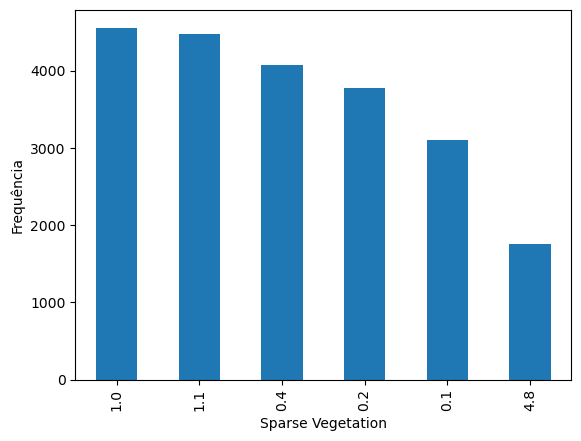

In [48]:
fig, ax = plt.subplots()
train_set.SparseVegetation.value_counts().plot(kind='bar',ax=ax);
ax.set_xlabel('Sparse Vegetation');
ax.set_ylabel('Frequência');

O que está acontecendo aqui é que os valores das variáveis do tipo landclass são idênticos para amostras de uma mesma região e amostras de regiões mais raras no dataset estão sendo consideradas outliers quando possuem um valor discrepante de outra região. Esses valores disrepantes são muito provavelmente devido a características distintas de cada região. Concluo, por isso, que esses outliers refentes às variáveis do tipo landclass não são erros, mas sim discrepâncias naturais de uma região para a outra.  

Legal, agora reduzimos drasticamente o número de variáveis cujos outliers devemos tratar de alguma forma. São estas:  
- FireArea  
- Precipitation
- RelativeHumidity
- SoilWaterContent
- WindSpeed
- VegetationIndex

Se eu quisesse ser rigoroso, deveria pesquisar a respeito da distribuição dessas variáveis na Austrália no geral. Por exemplo, um indíce de precipitação de 20 mm é muito extremo para os padrões da Austrália? Isso muda dependendo da época do ano? No entanto essa análise rigorosa está fora do escolpo deste projeto, por isso vou me limitar a substituir o valor dos outliers pelo valor dos limites inferiores e superiores. Exceto a variável FireArea, pois eu gostaria que o modelo fosse capaz de prever incêndios aberrantes também. 

### 5.3 - Distribuições

#### 5.3.1 - Distribuição da variável target

In [52]:
df=train_set.copy()

In [53]:
def removeOutliers(df,column):
    ser=df[column]
    IQR=ser.quantile(0.75)-ser.quantile(0.25)
    lim_inf=ser.quantile(0.25)-1.5*IQR
    lim_sup=ser.quantile(0.75)+1.5*IQR
    indexes=[]
    for i, value in ser.items():
        if value<lim_inf:
            df.loc[i,column]=lim_inf
        elif value>lim_sup:
            df.loc[i,column]=lim_sup

In [54]:
removeOutliers(df,'FireArea')

<Axes: ylabel='Frequency'>

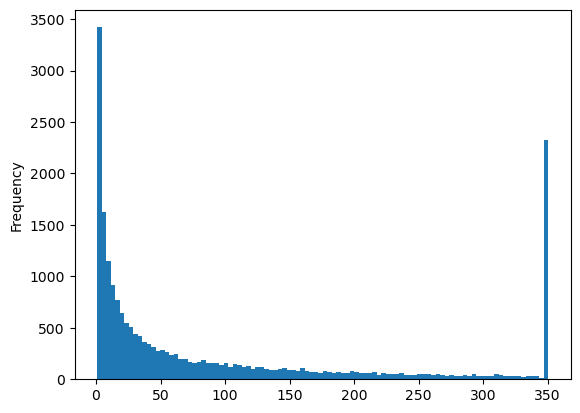

In [55]:
df.FireArea.plot(kind='hist',bins=100)

In [56]:
train_set.FireArea.skew()

8.100075697052308

In [57]:
df.FireArea.skew()

1.2200661681146576

Tratar os outliers diminuiu signiticativamente o desvio, mas parece que estamos lidando com uma distribuição exponencial. Vamos testar com o teste Anderson-Darling.

In [58]:
stats.anderson(df.FireArea.dropna().sample(5000), dist='expon')

AndersonResult(statistic=527.1011398208502, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0, scale=96.31744017675021)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

De fato a variável target segue uma distribuição exponencial. O que ocorre quando aplicamos uma transformação logarítimica?

<Axes: ylabel='Frequency'>

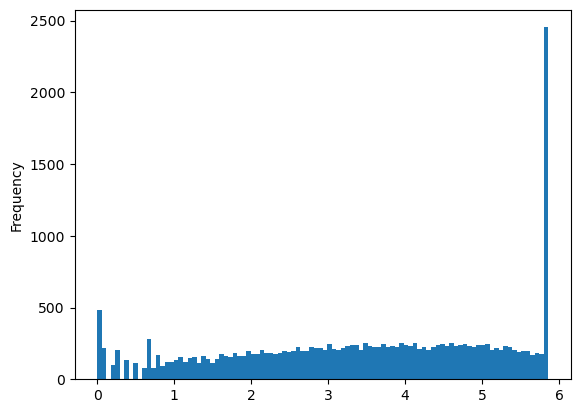

In [59]:
pd.Series(np.log(df.FireArea)).plot(kind='hist',bins=100)

In [60]:
np.log(df.FireArea).skew()

-0.309153218834885

In [61]:
np.log(df.FireArea).kurtosis()

-0.9776990350463972

In [62]:
stat, p = stats.shapiro(np.log(df.FireArea.dropna().sample(5000)))
print( 'Statistics\n(W)= %e,\n p = %e' % ( stat, p ) )

Statistics
(W)= 9.465703e-01,
 p = 3.010683e-39


Após a transformação, a variável continua não seguindo uma distribuição normal, mas reduzimos bastante a assimetria. 

<Axes: ylabel='Frequency'>

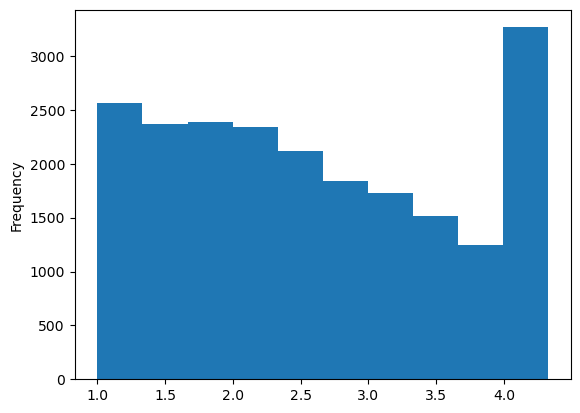

In [63]:
pd.Series(np.power(df.FireArea,1/4)).plot(kind='hist')

Tomar a raíz não apresenta um resultado melhor do que tomar o log. Concluo portanto que a melhor decisão é transformar logaritimicamente a variável target. 

#### 5.3.2 - Distribuição das features

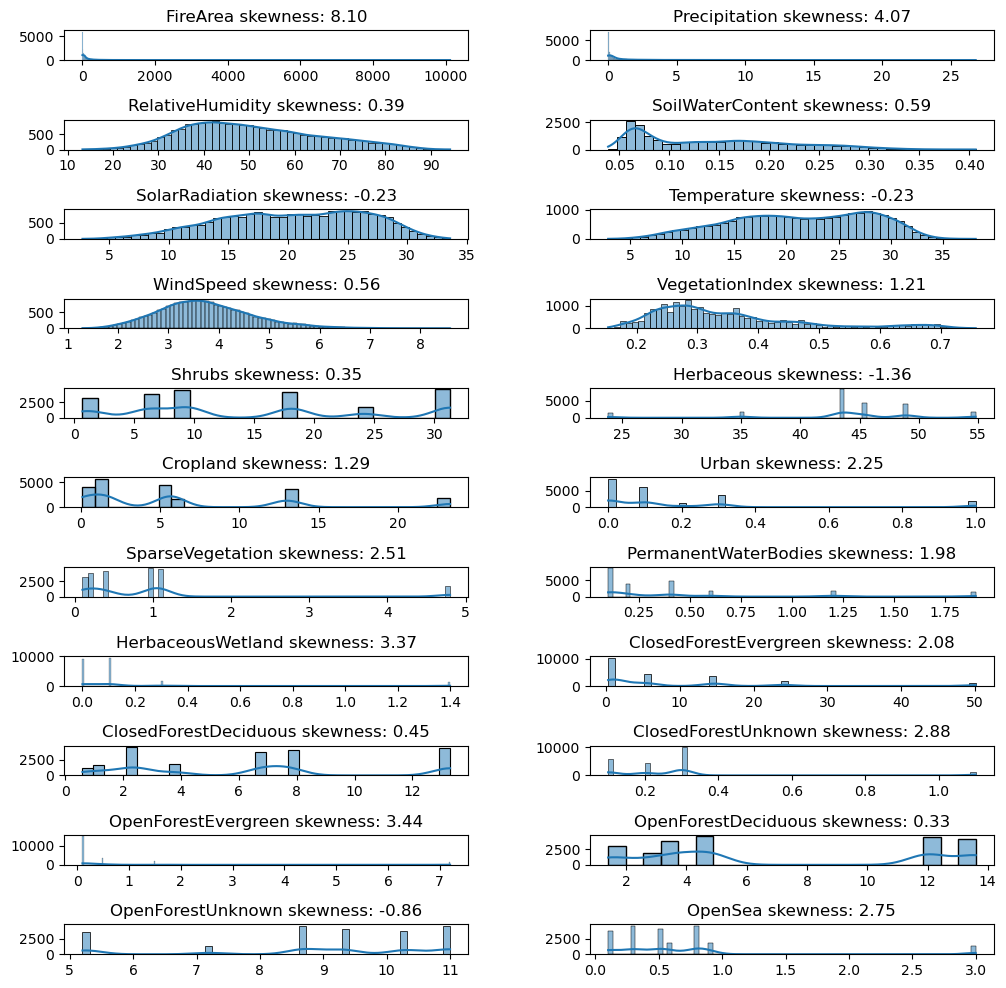

In [64]:
columns=np.array(train_set.iloc[:,2:].columns).reshape(11,2)

fig, ax = plt.subplots(11,2,figsize=(12,12))

for i in range(11):
    for j in range(2):
        skewness=stats.skew(train_set[columns[i,j]], axis=0, nan_policy='omit', bias=True)
        sns.histplot(train_set[columns[i,j]],ax=ax[i,j],kde=True)
        ax[i,j].set_title('{0} skewness: {1:.2f}'.format(columns[i,j],skewness))
        ax[i,j].set(xlabel=None,ylabel=None)
        
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=2)

Temos várias distribuições assimétricas, o que pode não ser bom para o treinamento de alguns modelos. Vamos ver se aplicando uma transformação logarítimica conseguimos uma distribuição mais simétrica!

In [109]:
print('Skewness before and after log transformation')
print()
for column in train_set.iloc[:,2:].columns:
    
    data=train_set[column]
    data_tr=np.log1p(data)
    skew=stats.skew(data, axis=0, nan_policy='omit', bias=True)
    skew_tr=stats.skew(data_tr, axis=0, nan_policy='omit', bias=True)
    if abs(skew_tr)<abs(skew):
        msg = '(Transformação BEM SUCEDIDA)'
    else: msg='(Transformação FALHOU)'
    print(column.title(), msg)
    print('{0:.2f} ----> {1:.2f}'.format(skew,skew_tr))
    print()
    

Skewness before and after log transformation

Firearea (Transformação BEM SUCEDIDA)
8.10 ----> 0.08

Precipitation (Transformação BEM SUCEDIDA)
4.07 ----> 1.69

Relativehumidity (Transformação BEM SUCEDIDA)
0.39 ----> -0.25

Soilwatercontent (Transformação BEM SUCEDIDA)
0.59 ----> 0.50

Solarradiation (Transformação FALHOU)
-0.23 ----> -0.93

Temperature (Transformação FALHOU)
-0.23 ----> -0.90

Windspeed (Transformação BEM SUCEDIDA)
0.56 ----> -0.05

Vegetationindex (Transformação BEM SUCEDIDA)
1.21 ----> 1.01

Shrubs (Transformação FALHOU)
0.35 ----> -0.77

Herbaceous (Transformação FALHOU)
-1.36 ----> -2.03

Cropland (Transformação BEM SUCEDIDA)
1.29 ----> -0.00

Urban (Transformação BEM SUCEDIDA)
2.25 ----> 1.88

Sparsevegetation (Transformação BEM SUCEDIDA)
2.51 ----> 1.45

Permanentwaterbodies (Transformação BEM SUCEDIDA)
1.98 ----> 1.52

Herbaceouswetland (Transformação BEM SUCEDIDA)
3.37 ----> 3.01

Closedforestevergreen (Transformação BEM SUCEDIDA)
2.08 ----> 0.49

Closedfores

Perfeito! Agora funcionou e a simetria das distribuições melhorou muito. Vale notar que a transformação fracassou em todos os casos em que o desvio era negativo, o que faz sentido, pois a transformação logarímitca é ideal para assimetrias positivas.

### 5.4 - Correlações

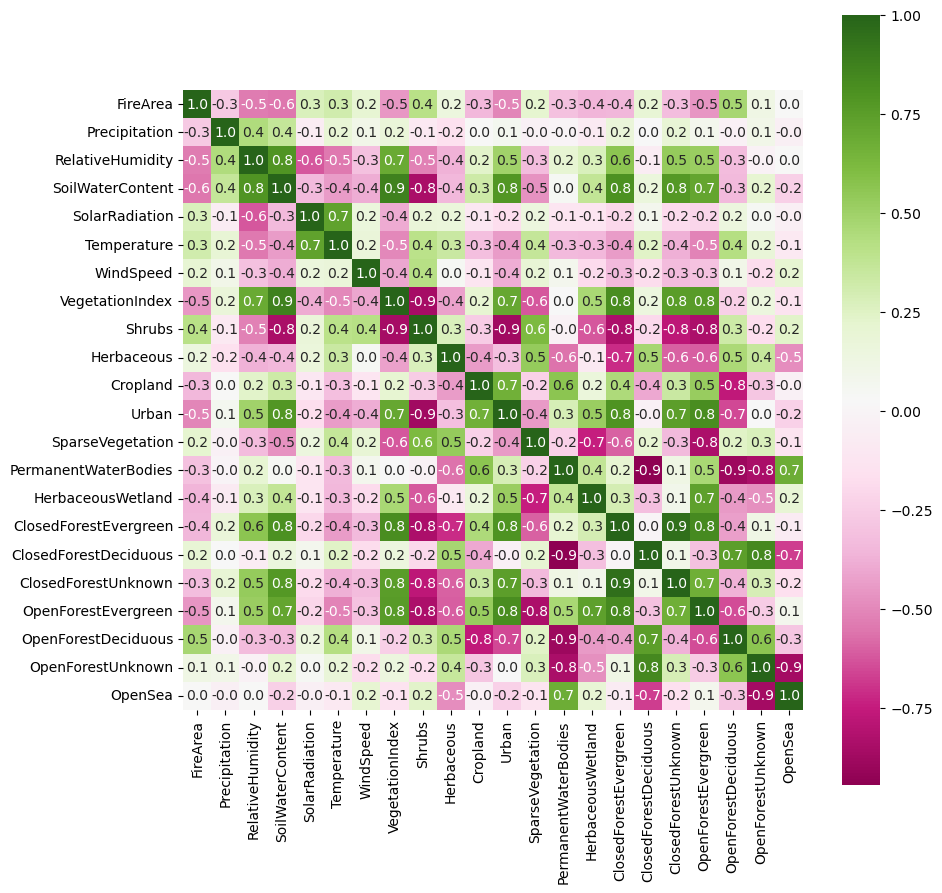

In [72]:
corr=train_set.corr(method='spearman',numeric_only=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap="PiYG",square=True,annot=True,fmt='.1f',ax=ax);

Vou utilizar três critérios para selecionar features com base na correlação de Spearman.  
1) Vão para o treinamento features cuja correlação com a target está acima de 0.3 ou abaixo de -0.3.
2) Se uma feature tiver alta correlação com outra, vou excluir uma das colunas. Isso porque não quero levar informação redundante para o treinamento do modelo. 
3) Se um scatterplot mostrar algum tipo de relação entre a coluna em questão e a target, essa coluna será selecionada.

In [73]:
columns_to_keep=list(corr.loc[abs(corr.FireArea)>=0.3,'FireArea'].index)
columns_to_keep

['FireArea',
 'RelativeHumidity',
 'SoilWaterContent',
 'Temperature',
 'VegetationIndex',
 'Shrubs',
 'Cropland',
 'Urban',
 'PermanentWaterBodies',
 'HerbaceousWetland',
 'ClosedForestEvergreen',
 'ClosedForestUnknown',
 'OpenForestEvergreen',
 'OpenForestDeciduous']

Reduzimos significativamente o número de colunas. 

Precipitation, que indica a quantidade de chuva no dia, não mostrou correlação significativa. Mas creio que vale a pena investigar melhor, uma vez que me parece muito natural que essa feature entre no treinamento do modelo. Não sou nenhum especialista, mas minha induição diz que chuva e quantidade de incêndios deveria ter uma correlação negativa.

<Axes: xlabel='Precipitation', ylabel='FireArea'>

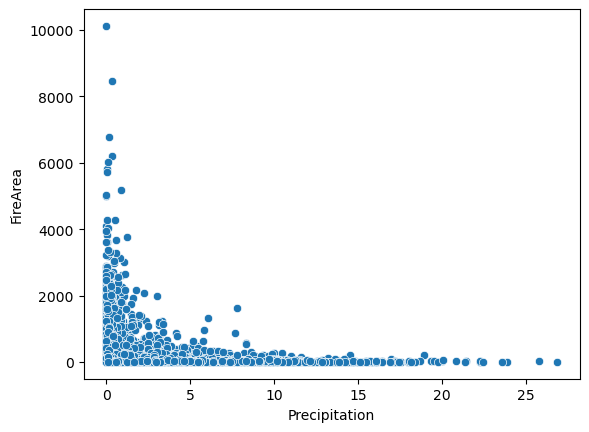

In [74]:
sns.scatterplot(data=train_set,x='Precipitation',y='FireArea')

Aparentemente temos uma correlação exponencial entre precipitação e a FireArea! Motivo suficiente para mantê-la no train_set.

In [75]:
columns_to_keep.append('Precipitation')

In [76]:
columns_to_keep

['FireArea',
 'RelativeHumidity',
 'SoilWaterContent',
 'Temperature',
 'VegetationIndex',
 'Shrubs',
 'Cropland',
 'Urban',
 'PermanentWaterBodies',
 'HerbaceousWetland',
 'ClosedForestEvergreen',
 'ClosedForestUnknown',
 'OpenForestEvergreen',
 'OpenForestDeciduous',
 'Precipitation']

In [77]:
train_set.columns

Index(['Region', 'Date', 'FireArea', 'Precipitation', 'RelativeHumidity',
       'SoilWaterContent', 'SolarRadiation', 'Temperature', 'WindSpeed',
       'VegetationIndex', 'Shrubs', 'Herbaceous', 'Cropland', 'Urban',
       'SparseVegetation', 'PermanentWaterBodies', 'HerbaceousWetland',
       'ClosedForestEvergreen', 'ClosedForestDeciduous', 'ClosedForestUnknown',
       'OpenForestEvergreen', 'OpenForestDeciduous', 'OpenForestUnknown',
       'OpenSea'],
      dtype='object')

Suspeito que SolarRadiation, WindSpeed e ClosedForestDecidious possam ter correlação com a target também. Vamos averiguar.

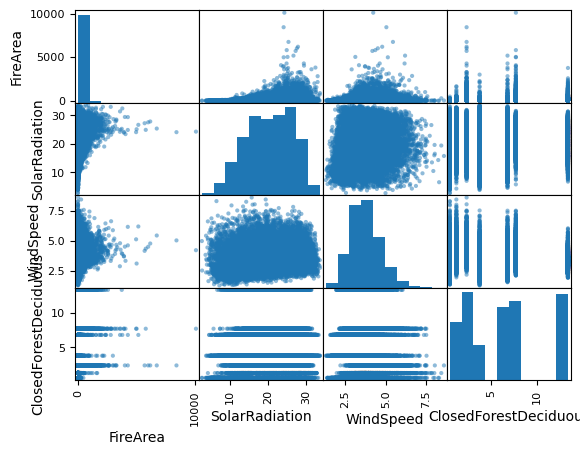

In [78]:
scatter_matrix(train_set[['FireArea','SolarRadiation', 'WindSpeed','ClosedForestDeciduous']]);

Este plot nos mostra que para valores maiores de SolarRadiation há uma maior ocorrência de valores maiores da variável FireArea. Algo semelhante ocorre com a variável WindSpeed, mas para valores intermediários. Quanto à ClosedForestDeciduous, para valores distintos, há diferentes ranges de FireArea. Concluo, portanto, que essas variáveis podem ser importantes para aumentar o poder preditivo do modelo.

Resta verificar se alguma feature selecionada tem alta correlação com outras. 

In [79]:
columns_to_keep+=['WindSpeed','SolarRadiation','ClosedForestDeciduous']

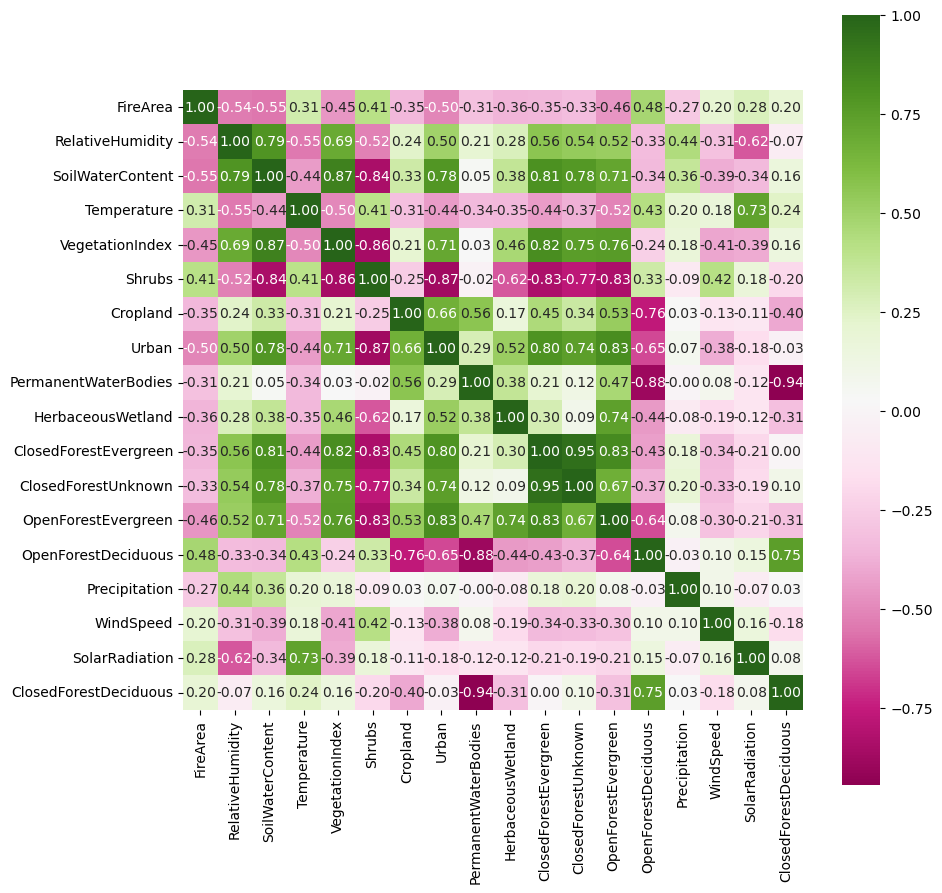

In [80]:
corr=train_set[columns_to_keep].corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap="PiYG",square=True,annot=True,fmt='.2f',ax=ax);

VegetationIndex apresenta alta correlação com diversas variáveis, a ponto de eu me sentir tentado a considerá-la redundante para o treinamento do modelo. No entanto, pelo fato dessa variável possuir uma distribuição muito mais contínua e normal do que as provenientes da tabela landclass, decidi mantê-la no conjunto. 

Vamos ver quais as variáveis que tem alta correlação com Shrubs.

In [81]:
corr[abs(corr.VegetationIndex)>0.75]

,FireArea,RelativeHumidity,SoilWaterContent,Temperature,VegetationIndex,Shrubs,Cropland,Urban,PermanentWaterBodies,HerbaceousWetland,ClosedForestEvergreen,ClosedForestUnknown,OpenForestEvergreen,OpenForestDeciduous,Precipitation,WindSpeed,SolarRadiation,ClosedForestDeciduous
SoilWaterContent,-0.550148,0.789920,1.000000,-0.439258,0.874762,-0.837188,0.331190,0.783402,0.048151,0.375154,0.806762,0.777527,0.714187,-0.337258,0.364688,-0.389176,-0.338828,0.163448
VegetationIndex,-0.453434,0.690447,0.874762,-0.501042,1.000000,-0.857071,0.213608,0.710828,0.025377,0.463202,0.819541,0.751059,0.758347,-0.241736,0.176288,-0.410137,-0.392491,0.155206
Shrubs,0.411902,-0.522425,-0.837188,0.406150,-0.857071,1.000000,-0.254309,-0.871079,-0.024809,-0.617194,-0.833274,-0.772831,-0.834154,0.329137,-0.086403,0.418780,0.179795,-0.196192
ClosedForestEvergreen,-0.353716,0.561302,0.806762,-0.438819,0.819541,-0.833274,0.449687,0.797024,0.212941,0.296367,1.000000,0.948592,0.834154,-0.429650,0.177447,-0.341817,-0.206027,0.004111
ClosedForestUnknown,-0.327878,0.536674,0.777527,-0.374760,0.751059,-0.772831,0.341454,0.744407,0.123325,0.094662,0.948592,1.000000,0.669570,-0.373700,0.200371,-0.333287,-0.185398,0.102090
OpenForestEvergreen,-0.458269,0.519219,0.714187,-0.516562,0.758347,-0.834154,0.527207,0.825214,0.468404,0.736153,0.834154,0.669570,1.000000,-0.644765,0.077592,-0.304918,-0.212474,-0.311418


In [82]:
columns_to_drop=['SoilWaterContent','ClosedForestEvergreen','ClosedForestUnknown','OpenForestEvergreen','Shrubs']

for column in columns_to_drop:
    columns_to_keep.remove(column)

In [83]:
columns_to_keep

['FireArea',
 'RelativeHumidity',
 'Temperature',
 'VegetationIndex',
 'Cropland',
 'Urban',
 'PermanentWaterBodies',
 'HerbaceousWetland',
 'OpenForestDeciduous',
 'Precipitation',
 'WindSpeed',
 'SolarRadiation',
 'ClosedForestDeciduous']

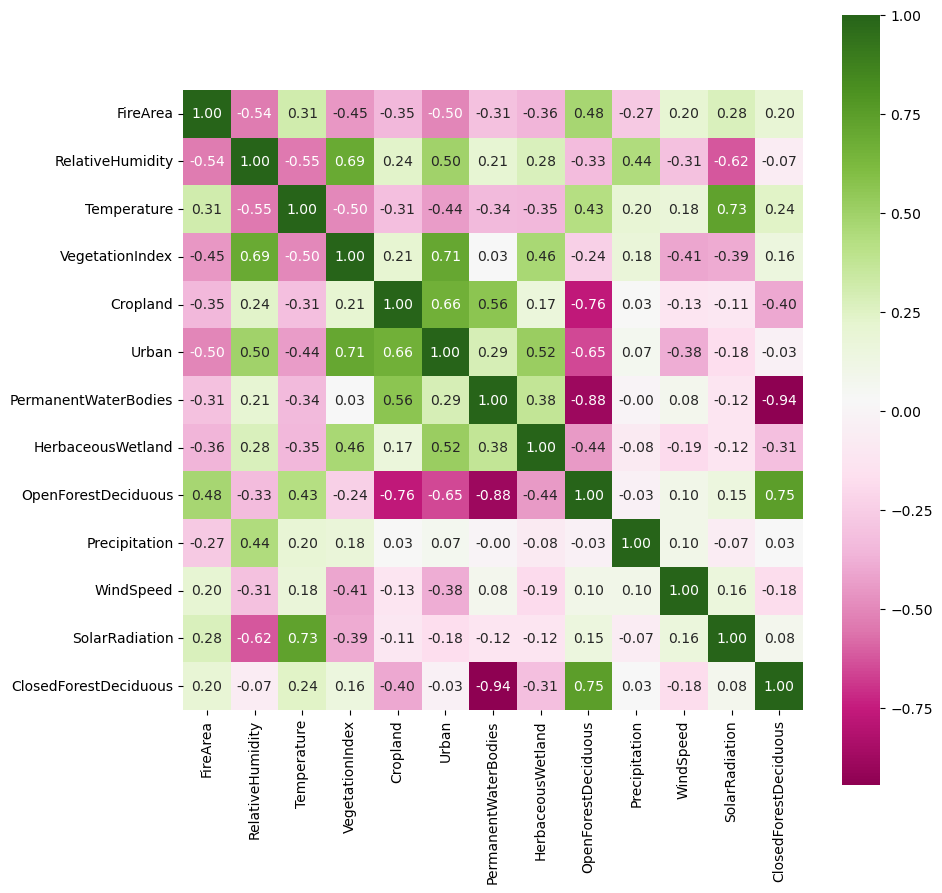

In [84]:
corr=train_set[columns_to_keep].corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap="PiYG",square=True,annot=True,fmt='.2f',ax=ax);

Vou remover também Cropland e PermanentWaterBodies, que apresentam alta correlação com OpenForestDecidious, cuja correlação com a target é maior do que a das outras duas.

In [85]:
columns_to_keep.remove('Cropland')

In [86]:
columns_to_keep.remove('PermanentWaterBodies')

In [87]:
train_set[columns_to_keep]

,FireArea,RelativeHumidity,Temperature,VegetationIndex,Urban,HerbaceousWetland,OpenForestDeciduous,Precipitation,WindSpeed,SolarRadiation,ClosedForestDeciduous
14338,101.701228,45.608217,29.203871,0.312184,0.1,0.0,12.0,0.289954,3.200446,26.975425,13.3
5865,127.212286,45.631752,22.848981,0.236369,0.0,0.1,13.6,0.554936,3.978657,18.840768,7.7
18705,19.880000,78.565481,12.988923,0.685395,0.2,1.4,1.5,0.216376,1.943799,14.531355,0.6
21753,54.562759,35.120478,20.787359,0.225792,0.0,0.0,4.8,0.049332,3.838577,25.677872,2.4
1206,2.415000,44.924688,22.281894,0.362676,0.3,0.1,3.7,0.367479,2.804165,20.702037,6.8
...,...,...,...,...,...,...,...,...,...,...,...
21575,146.666667,41.296972,28.750511,0.244422,0.0,0.0,4.8,0.090229,3.630172,18.636779,2.4
5390,41.250000,49.891283,22.181654,0.349490,0.0,0.1,13.6,0.726415,4.712530,24.004515,7.7
860,5.267500,43.092057,23.189542,0.344548,0.3,0.1,3.7,0.608848,4.084320,23.978776,6.8
15795,1.000000,33.937552,28.318849,0.177044,0.1,0.1,1.4,0.097970,3.714231,29.298302,1.3


In [88]:
with open('columns_to_keep.pkl', 'wb') as f: 
    pickle.dump(columns_to_keep, f) # serialize the grid_search object

## 6 - Construindo o pipeline de pré-processamento dos dados

In [89]:
X=train_set[columns_to_keep].drop('FireArea',axis=1)
y=train_set['FireArea'].copy()

In [90]:
X.head()

,RelativeHumidity,Temperature,VegetationIndex,Urban,HerbaceousWetland,OpenForestDeciduous,Precipitation,WindSpeed,SolarRadiation,ClosedForestDeciduous
14338,45.608217,29.203871,0.312184,0.1,0.0,12.0,0.289954,3.200446,26.975425,13.3
5865,45.631752,22.848981,0.236369,0.0,0.1,13.6,0.554936,3.978657,18.840768,7.7
18705,78.565481,12.988923,0.685395,0.2,1.4,1.5,0.216376,1.943799,14.531355,0.6
21753,35.120478,20.787359,0.225792,0.0,0.0,4.8,0.049332,3.838577,25.677872,2.4
1206,44.924688,22.281894,0.362676,0.3,0.1,3.7,0.367479,2.804165,20.702037,6.8


Para otimizar a preparação dos dados para o treinamento do modelo, vou utilizar a classe Pipeline do Sckit-Learn. Utilizarei a classe SimpleImputer e StandardScaler para lidar com os NaNs e e padronizar a escala dos dados, respectivamente. 
Quanto aos outliers, abaixo crio uma classe customizada para isso. Os métodos fit e transform, junto com os métodos herdados da classe TransformerMixin, permitem que essa classe funcione como um transformador com o qual a classe Pipeline sabe lidar. Construí essa classe de tal forma que é possível testar a perfomance do modelo com ou sem a substituição dos outliers. 

In [5]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    
    def __init__(self,on=True):
        self.on=on
    
    def fit(self,X, y=None):
        return self
    
    def transform(self,arr):
        X=arr.copy()
        if self.on:
            if len(X)>1:
                for column in range(X.shape[1]):
                    ser=X[:,column]
                    q1=np.quantile(ser,0.25)
                    q3=np.quantile(ser,0.75)
                    iqr=q3-q1
                    inf=q1-1.5*iqr
                    sup=q3+1.5*iqr
                    for row, value in np.ndenumerate(ser):
                        if value<inf:
                            X[row,column]=inf
                        elif value>sup:
                            X[row,column]=sup
            else:
                q1=np.quantile(X,0.25)
                q3=np.quantile(X,0.75)
                iqr=q3-q1
                inf=q1-1.5*iqr
                sup=q3+1.5*iqr
                for i, value in X.iteritems():
                    if value<inf:
                        X[i]=inf
                    elif value>sup:
                        X[i]=sup
                
        return X

Abaixo defino a classe responsável pela transformação logarítimica dos dados.

In [6]:
class LogTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,on=True):
        self.on=on
    
    def fit(self,X, y=None):
        return self
    
    def transform(self,arr):
        X=arr.copy()
        if self.on:
            return np.log1p(X)

In [8]:
pipeline_weather_vegetation_skew = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('outlier_handler', OutlierHandler(on=True)),
('log_transformer',LogTransformer(on=True)),
('std_scaler',StandardScaler())
])

pipeline_weather_vegetation_no_skew = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('outlier_handler', OutlierHandler(on=True)),
('std_scaler',StandardScaler())
])

pipeline_landclass=Pipeline([
('imputer', SimpleImputer(strategy="median")),
('log_transformer',LogTransformer(on=True)),
('std_scaler',StandardScaler())
])

weather_vegetation_skew=['RelativeHumidity','VegetationIndex', 'WindSpeed', 'Precipitation']
weather_vegetation_no_skew=['Temperature','SolarRadiation']
landclass_columns=['Urban','HerbaceousWetland','OpenForestDeciduous','ClosedForestDeciduous']

features_pipeline=ColumnTransformer([
('weather_vegetation_skew', pipeline_weather_vegetation_skew , weather_vegetation_skew),
('weather_vegetation_no_skew', pipeline_weather_vegetation_no_skew,weather_vegetation_no_skew),
('landclass', pipeline_landclass, landclass_columns),
])

Perfeito. Agora que temos nosso pipeline de pré-processamento é hora de treinar alguns modelos. 

## 7 - Cross-Validation: testando diferentes modelos

In [17]:
X_tr=features_pipeline.fit_transform(X)
y_tr=np.log1p(y.fillna(y.median()).ravel())

Quero avaliar o modelo com a métrica RMSE. Mas como apliquei a transformação log(x+1) na target essa métrica não terá unidade, pois envolveria substração de logs, o que torna difícil sua interpretação. Por isso criarei uma função score personalizada. A ideia consiste em transformar a previsão e a variável y_tr de volta para a unidade km² antes de calcular o MSE. 

In [20]:
def customMSE(y_truth, y_pred):
    new_y_truth=np.exp(y_truth)
    new_y_pred=np.exp(y_pred)
    return mean_squared_error(new_y_truth, new_y_pred)

custom_negative_mse=make_scorer(customMSE,greater_is_better=False)

Abaixo eu utilizo cross-validation para testar três modelos de regressão diferentes: Random Forest Regression, Linear Regression e Decision Tree Regression. A métrica que escolhi para avaliar o desempenho foi a RMSE. Note que a operação math.exp(mean_rmse)-1 deve ser efetuada para que se possa interpretar o RMSE, uma vez que a target foi transformada utilizando a transformação log(x+1).

In [113]:
%%time
models_to_be_tested={'LinearRegression':LinearRegression(),'RandomForestRegressor':RandomForestRegressor(),
                     'DecisionTreeRegressor':DecisionTreeRegressor(),'SupportVectorRegression':SVR()}

def test(model_name):
    
    model=models_to_be_tested[model_name]
    scores = cross_val_score(model, X_tr, y_tr,scoring=custom_negative_mse, cv=10)
    mean_rmse = np.sqrt(-scores.mean())
    print(f'{model_name} RMSE: {mean_rmse:.3f} km²')
          
print('-'*50)
for model_name in models_to_be_tested:
          test(model_name)
          print('-'*50)

--------------------------------------------------
LinearRegression RMSE: 301.462 km²
--------------------------------------------------
RandomForestRegressor RMSE: 247.055 km²
--------------------------------------------------
DecisionTreeRegressor RMSE: 317.571 km²
--------------------------------------------------
SupportVectorRegression RMSE: 281.499 km²
--------------------------------------------------
CPU times: total: 8min 9s
Wall time: 10min 59s


O modelo de floresta randômica apresentou a melhor performance. Mas ele foi treinado com os hiperparâmetros padrão. Está na hora de tunar o modelo.  

## 8 - Grid Search: encontrando os melhores hiperparâmetros 

In [114]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg=RandomForestRegressor()

In [115]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring=custom_negative_mse,return_train_score=True,error_score='raise')

In [116]:
%%time
grid_search.fit(X_tr, y_tr)

CPU times: total: 2min 28s
Wall time: 3min 28s


GridSearchCV(cv=5, error_score='raise', estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True,
             scoring=make_scorer(customMSE, greater_is_better=False))

In [117]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

In [118]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),'km²', params)

266.3952207169606 km² {'max_features': 2, 'n_estimators': 3}
264.2287463154045 km² {'max_features': 2, 'n_estimators': 10}
262.7926639126295 km² {'max_features': 2, 'n_estimators': 30}
269.14986256299227 km² {'max_features': 4, 'n_estimators': 3}
257.3216606901072 km² {'max_features': 4, 'n_estimators': 10}
256.5267705830464 km² {'max_features': 4, 'n_estimators': 30}
257.79680660058335 km² {'max_features': 6, 'n_estimators': 3}
252.984767799922 km² {'max_features': 6, 'n_estimators': 10}
251.9477091464742 km² {'max_features': 6, 'n_estimators': 30}
265.928727496534 km² {'max_features': 8, 'n_estimators': 3}
253.59328981746552 km² {'max_features': 8, 'n_estimators': 10}
251.3215187694329 km² {'max_features': 8, 'n_estimators': 30}
266.1940584045072 km² {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
258.77759352660956 km² {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
258.914919322753 km² {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
249.22784549231

O melhor modelo performou ligeiramente pior do que o modelo treinado com os hiperparâmetros padrões. No entanto o modelo ainda pode melhorar. Note que o melhor valor de n_estimators foi o valor máximo da grade de parâmetros que eu defini para boostrap=False; o padrão é 100. Vamos experimentar então com valores maiores de n_estimators. Modelos com max_features=2 performaram pior, por isso vou excluir esse valor da param_grid.  

In [119]:
param_grid = [
{'n_estimators': [10,50,100,110,120], 'max_features': [4, 6, 8],'bootstrap': [False]}
]
forest_reg=RandomForestRegressor()

In [120]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring=custom_negative_mse,return_train_score=True,error_score='raise')

In [121]:
%%time
grid_search.fit(X_tr, y_tr)

CPU times: total: 22min 12s
Wall time: 29min 55s


GridSearchCV(cv=5, error_score='raise', estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [4, 6, 8],
                          'n_estimators': [10, 50, 100, 110, 120]}],
             return_train_score=True,
             scoring=make_scorer(customMSE, greater_is_better=False))

In [122]:
with open('forest_grid_search.pkl', 'wb') as f: 
    pickle.dump(grid_search, f) 

In [123]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 50}

In [124]:
np.sqrt(-grid_search.best_score_)

236.3046327233377

Conseguimos melhorar a score! Por padrão, a classe GridSearchCV treina o melhor modelo novamente utilizando todo o conjunto de treino.
Resta agora salvar esse modelo e partir para a fase de teste.

In [125]:
final_model=grid_search.best_estimator_

In [126]:
with open('final_model.pkl', 'wb') as f: 
    pickle.dump(final_model, f) # serialize the grid_search object

## 9 - Avaliação do modelo com o conjunto de teste

Agora chegou a hora de ver se o modelo final generaliza bem. 

In [15]:
with open('columns_to_keep.pkl', 'rb') as f, open('final_model.pkl', 'rb') as g:

    columns_to_keep = pickle.load(f)
    final_model = pickle.load(g)

In [16]:
train_set=pd.read_csv('train_set.csv')
X=train_set[columns_to_keep].drop('FireArea',axis=1)
y=train_set['FireArea'].copy()

X_tr=features_pipeline.fit_transform(X)
y_tr=np.log1p(y.fillna(y.median()).ravel())

test_set=pd.read_csv('test_set.csv')
X_test=test_set[columns_to_keep].drop('FireArea',axis=1)
y_test=test_set['FireArea'].copy()

X_test_tr=features_pipeline.transform(X_test)
y_test_tr=np.log1p(y_test.fillna(y.median()).ravel())

In [18]:
%%time
final_predictions = final_model.predict(X_test_tr)

CPU times: total: 125 ms
Wall time: 157 ms


In [21]:
final_rmse=np.sqrt(customMSE(y_test_tr,final_predictions))

In [22]:
final_rmse

207.69426431706378

O modelo performou melhor no conjunto de teste, o que é um sinal de que não houve overfitting. 

In [23]:
final_predictions_km2 = pd.Series(np.exp(final_predictions))

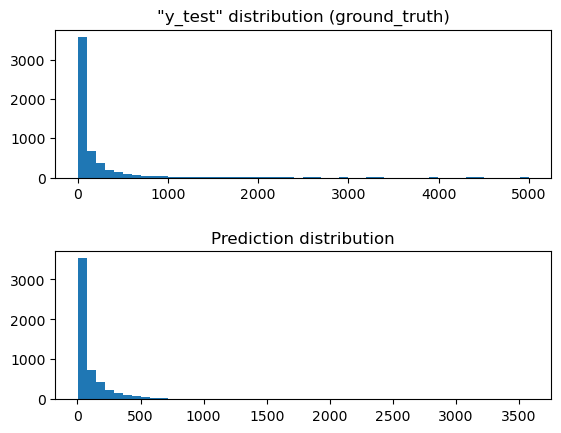

In [138]:
fig, ax = plt.subplots(2)
pd.Series(final_predictions_km2).hist(bins=50, ax = ax[1],label='y_prediction');
y_test.hist(bins=50,ax=ax[0],label='y_test');
ax[0].set_title('"y_test" distribution (ground_truth)');
ax[1].set_title('Prediction distribution');
ax[0].grid(False)
ax[1].grid(False)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)

In [136]:
final_predictions_km2.describe()

count    5438.000000
mean      105.288666
std       186.159090
min         2.577202
25%        13.293442
50%        36.341728
75%       124.730349
max      3575.543119
dtype: float64

In [137]:
y_test.describe()

count    5345.000000
mean      147.746233
std       304.006568
min         1.000000
25%         9.107143
50%        38.427037
75%       151.582857
max      4997.535176
Name: FireArea, dtype: float64

Tanto a previsão quanto a y_set seguem uma distribuição exponencial. No entanto a previsão não foi capaz de prever valores maiores do que 3575. Talvez isso explique o tamanho exacerbado do RMSE.

Vamos ver como o modelo performou em diferentes ranges da variável target. 

In [26]:
ground_truth=y_test.reset_index().drop('index',axis=1)

Valores menores do que a mediana de t_test:

In [34]:
mask=ground_truth.FireArea<ground_truth.FireArea.quantile(0.5)
indexes_median=ground_truth[mask].index
np.sqrt(customMSE(y_test_tr[indexes_median],final_predictions[indexes_median]))

36.512406066708074

Valores na região interquartil:

In [35]:
mask=(ground_truth.FireArea>ground_truth.FireArea.quantile(0.25)) & (ground_truth.FireArea<ground_truth.FireArea.quantile(0.75))
indexes_iqr=ground_truth[mask].index
np.sqrt(customMSE(y_test_tr[indexes_iqr],final_predictions[indexes_iqr]))

64.1779225154973

Valores acima do terceiro quartil:

In [36]:
mask=ground_truth.FireArea>ground_truth.FireArea.quantile(0.75)
indexes_q3=ground_truth[mask].index
np.sqrt(customMSE(y_test_tr[indexes_q3],final_predictions[indexes_q3]))

408.4546074379595

Muito interessante! O modelo parece prever com maior acurácia valores menores e tende a errar mais em ranges mais elevados. 

Abaixo eu computo os erros elemento por elemento e ploto sua distribuição para cada range. 

Text(0.5, 1.0, '> 3ºQ')

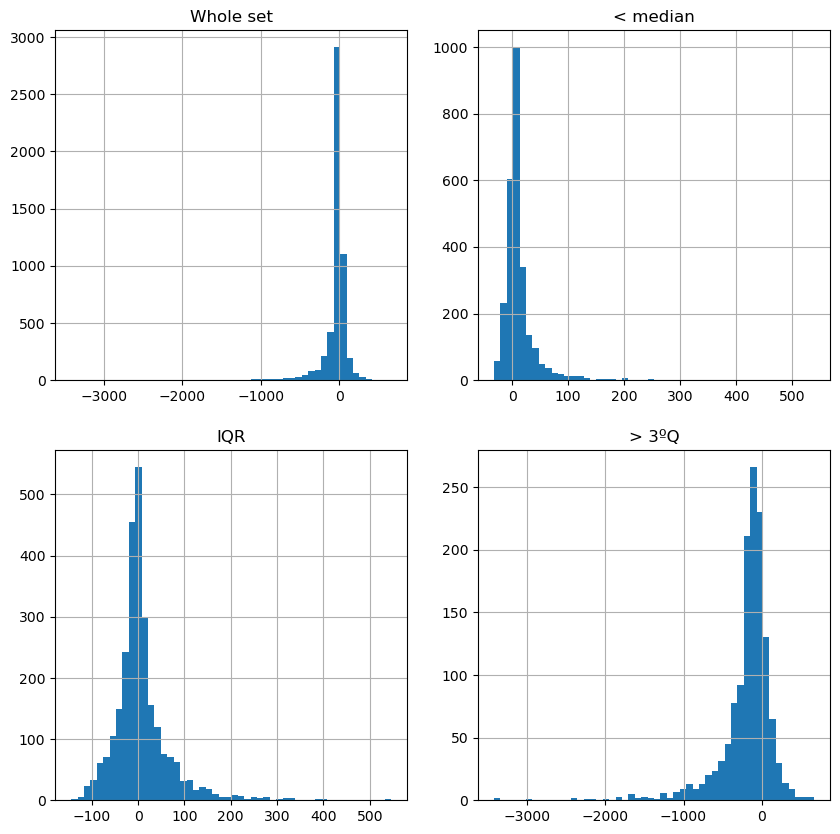

In [55]:
erros=final_predictions_km2-ground_truth.FireArea

fig, ax = plt.subplots(2,2,figsize=(10,10))
erros.hist(bins=50,ax=ax[0,0])
ax[0,0].set_title('Whole set')
erros[indexes_median].hist(bins=50,ax=ax[0,1])
ax[0,1].set_title('< median')
erros[indexes_iqr].hist(bins=50,ax=ax[1,0])
ax[1,0].set_title('IQR')
erros[indexes_q3].hist(bins=50,ax=ax[1,1])
ax[1,1].set_title('> 3ºQ')

Pela maneira que eu defini o erro, valores positivos significam que a previsão é maior do que a realidade e valores negativos significam que a previsão é menor do que a realidade.  
De acordo com esses histogramas, quanto mais elevado o range, maior o número de desvios negativos, ou seja, o modelo tende a errar para baixo quando a realidade consiste de valores mais altos.

In [57]:
abs(erros).describe()

count    5345.000000
mean       83.686753
std       191.850652
min         0.000736
25%         7.148102
50%        23.452219
75%        80.129255
max      3419.268212
dtype: float64

Dessa tabela conseguimos algumas informações mais quantitativas sobre a distribuição da magnitude dos erros. Podemos ver, por exemplo, que em 50% das previsões o erro absoluto cometido foi menor do que 23.45 km². 

## 10 - Conclusão

Comecei com quatro tabelas e após um pouco de data wrangling obtive a tabela final, organizada de tal maneira que a execução do pipeline de pré-processamento a deixa preparada para o treinamento do modelo.  
  
Construí classes customizadas de transformação de tal maneira que pode-se testar o treinamento do modelo com ou sem essas transformações. Desenvolvi também uma métrica customizada que desfaz a transformação logarítimica aplicada à variável target antes de avaliar a previsão com o MSE. 

Com os resultados da análise exploratória dos dados, selecionei as features que devem ir para o treinamento do modelo (columns_to_keep), quais features devem ser transformadas e como os NaNs e outliers devem ser tratados em cada uma delas. 

Através da técnica de cross-validation, decidi que o modelo Random Forest era o melhor dentre os candidatos para esta situação. Depois tunei o modelo final utilizando grid search. Uma vez treinado com o conjunto de treino todo, o modelo foi salvo no formato .pkl e parti para o conjunto de teste. 

Os resultados foram interessantes, apesar da utilidade prática do modelo ser questionável:  
- O modelo obteve uma score melhor no conjunto de teste do que no conjunto de treino, o que significa que ele generalizou bem e não houve overfitting.
- A previsão aparenta seguir uma distribuição exponencial, tal como a target no conjunto de teste e de treino. 
- Apesar do RMSE da previsão final ser de aproximadamente 208 km², verifiquei que este erro só possui essa magnitude exacerbada quando o modelo tenta prever incêndios maiores. Nesses casos, o resultado da previsão tendem a ser valores muito menores do que os reais. Na realidade, em 50% dos casos, o erro cometido foi menor do que 23.45 km².  

A grande questão que surge é: **por que o modelo é melhor em prever incêndios pequenos?** Algumas explicações me vêm em mente. Uma delas é que o tratamento dos outliers pode ter corrompido os dados, de maneira que o modelo perde o poder de distinguir um incêndio pequeno de um incêndio grande, o que explicaria a alta ocorrência de previsões para baixo quando ocorreram incêndios de magnitude mais elevada. Nesse caso, seriam então os outliers nas features meras ocorrências de condições atípicas que explicam incêndios de tamanhos atípicos? Se eu fosse dar continuidade para este projeto, valeria a pena averiguar isso; bastaria treinar o modelo sem remover os outliers. Eu poderia ter escrito um único pipeline que faz o pré-processamento e a predição final para testar as duas possibilidades na fase de tunagem do modelo, mas não o fiz para que esta etapa não levasse o dobro do tempo. Numa situação real e com o hardware adequado isso não seria um problema. 

É possível também que eu tenha sido muito grosseiro na seleção das features e removi features que não deveria, talvez devesse ter aplicado mais tempo na procura de correlações não lineares ou talvez ter sido menos rígido com features que apresentavam alta correlação entre si (coloquei 0.75 e -0.75 como limiar, mas talvez o módulo desses valores deveriam ser maiores). 

Enfim, foi muito divertido todo esse processo. Espero que aqueles que tiveram a paciência de caminhar até aqui comigo por todos os passos do meu raciocínio tenham gostado ou no mínimo sintam-se convidados a me retornar com sugestões de melhoria :) 